In [ ]:
import torch
torch.manual_seed(123)

In [ ]:
# Fastai is required by eb_ml_battery_lib
!pip install fastai==2.5.3 -q
# import
import pandas as pd
import numpy as np
import sys
from fastai.tabular import *
# Load EB_ML python libraries
# The following libraries are used in this notebook and should be installed in your local machine before running this notebook.
# eb_colab_utils.py
# eb_ml_battery_lib.py
# eb_ml_utils.py

# path to load external *.py files used in this notebook
# Note: in Google Colab virtual machine you shoud copy the files in "/content" folder after BEFORE running this notebook's cell
external_python_file_path='../src'
sys.path.append(external_python_file_path)


from eb_ml_colab_utils import get_root_path,copy_model_to_google_drive
from eb_ml_battery_lib import load_soc_dataset
from eb_ml_utils import show_pair_plot,show_coorelation_plot

In [ ]:
#configuration dictionary
config ={}

# Root working folder (local or Google Drive)
# config['ROOT_DIR'] = get_root_path("batterie")
config['ROOT_DIR'] = get_root_path("..")  

# Folder with dataset in CSV format
#config['DATASETS_DIR'] = config['ROOT_DIR']+"/datasets"
config['DATASETS_DIR'] = config['ROOT_DIR']+"/datasets/EIS-vs-SOC-May2022"

# List of SoC level into dataset
#config['soc_list']=['100','090','080','070','060','050','040','030','020','010']
config['soc_list']=['100','090','080','070','060','050','040','030','020','010']

# Data acquition file to load from dateset folder
battery_list=["02_1","02_2","02_3","02_4","02_5","02_6","02_7","02_8","02_9"]
dataset,feature_col_names=load_soc_dataset(battery_list,config["soc_list"],config['DATASETS_DIR'])

In [ ]:
dataset

In [ ]:
dataset.reset_index(drop=True,inplace=True)
dataset['SOC_float'] = dataset.SOC.astype('float')
dataset['SOC_category'] = dataset.SOC.astype('category')

In [ ]:
from cmath import phase, polar, rect
df=dataset[feature_col_names]
df_phi= df.apply(lambda col: col.apply(lambda val: phase(val)))
df_abs= df.apply(lambda col: col.apply(lambda val: abs(val)))

In [ ]:
df_commn=dataset[['SOC_float','BATTERY_ID','EIS_ID']]
dataset_polar= df_phi.join(df_abs,lsuffix='_abs' , rsuffix="_phi")
dataset_polar= df_commn.join(dataset_polar)
print(dataset_polar)

## Regression

In [ ]:
from fastai.tabular.all import *

In [ ]:
polar_feature_names= list()
for feat_name in feature_col_names:
    polar_feature_names.append(feat_name+"_phi")
    polar_feature_names.append(feat_name+"_abs")

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(dataset_polar))

In [ ]:
#Path / default location for saving/loading models
path = '.models'

#The dependent variable/target
dep_var = 'SOC_float'

#The list of categorical features in the dataset
cat_names = ['BATTERY_ID', 'EIS_ID'] 

#The list of continuous features in the dataset
#Exclude the Dependent variable 'Price'
cont_names =polar_feature_names

#List of Processes/transforms to be applied to the dataset
procs = [FillMissing, Categorify, Normalize]


In [ ]:
dataset_polar['SOC_float']

# Regression with Tabular Learner - Polar 

In [ ]:
to = TabularPandas(dataset_polar, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = polar_feature_names,
                   y_names='SOC_float',
                   splits=splits)

In [54]:
dls = to.dataloaders(bs=64)
dls.show_batch()

,BATTERY_ID,EIS_ID,Z_f0_phi,Z_f0_abs,Z_f1_phi,Z_f1_abs,Z_f2_phi,Z_f2_abs,Z_f3_phi,Z_f3_abs,Z_f4_phi,Z_f4_abs,Z_f5_phi,Z_f5_abs,Z_f6_phi,Z_f6_abs,Z_f7_phi,Z_f7_abs,Z_f8_phi,Z_f8_abs,Z_f9_phi,Z_f9_abs,Z_f10_phi,Z_f10_abs,Z_f11_phi,Z_f11_abs,Z_f12_phi,Z_f12_abs,Z_f13_phi,Z_f13_abs,SOC_float
0,02,02_2,0.066397,-0.049002,0.065493,-0.036716,0.064428,-0.027389,0.064123,-0.018470,0.063704,-0.017715,0.063454,-0.023128,0.062912,-0.034890,0.061482,-0.054801,0.059764,-0.075621,0.057330,-0.090893,0.053756,-0.098188,0.051254,-0.092469,0.049176,-0.081837,0.047092,-0.061023,30.0
1,02,02_8,0.101817,-0.036997,0.100598,-0.028657,0.099891,-0.020880,0.099492,-0.015668,0.098721,-0.018188,0.098024,-0.022905,0.097313,-0.030299,0.095309,-0.045312,0.092717,-0.060087,0.089833,-0.066140,0.086173,-0.066094,0.083331,-0.064468,0.081041,-0.057270,0.078212,-0.045150,30.0
2,02,02_4,0.107352,-0.059019,0.105128,-0.046781,0.103782,-0.033920,0.102890,-0.027206,0.101242,-0.024786,0.100645,-0.028663,0.099943,-0.033542,0.097540,-0.048751,0.094878,-0.063136,0.091954,-0.073136,0.087383,-0.076262,0.084320,-0.070290,0.081766,-0.061878,0.078904,-0.043637,80.0
3,02,02_4,0.105156,-0.036919,0.103919,-0.030786,0.103118,-0.019522,0.102858,-0.016655,0.101983,-0.016869,0.101467,-0.023063,0.100521,-0.030984,0.098564,-0.048119,0.095800,-0.062733,0.092644,-0.070795,0.088361,-0.073457,0.085226,-0.068831,0.082631,-0.061088,0.080012,-0.043615,30.0
4,02,02_2,0.068625,-0.070121,0.067005,-0.055331,0.065907,-0.040287,0.065170,-0.030203,0.064213,-0.027862,0.063730,-0.031242,0.062972,-0.037549,0.061593,-0.059244,0.059618,-0.080137,0.057188,-0.096229,0.053310,-0.104746,0.050705,-0.100592,0.048370,-0.088990,0.046066,-0.064710,90.0
5,02,02_4,0.106756,-0.060817,0.104446,-0.050433,0.103011,-0.034856,0.102151,-0.029420,0.100713,-0.024489,0.099968,-0.027388,0.098568,-0.033507,0.096800,-0.045499,0.094515,-0.060765,0.091589,-0.069376,0.087170,-0.073324,0.084175,-0.069462,0.081653,-0.060098,0.078953,-0.045260,70.0
6,02,02_6,0.106695,-0.036761,0.105517,-0.030668,0.104535,-0.021143,0.104247,-0.015529,0.103252,-0.017165,0.102712,-0.023937,0.102106,-0.031970,0.099679,-0.049136,0.097018,-0.061816,0.093988,-0.069727,0.089679,-0.071171,0.086834,-0.067547,0.084164,-0.059555,0.081447,-0.044190,30.0
7,02,02_1,0.069331,-0.070242,0.067860,-0.052779,0.066629,-0.038375,0.066167,-0.028380,0.065121,-0.025645,0.064861,-0.028253,0.064078,-0.041702,0.062618,-0.062241,0.060670,-0.080321,0.058052,-0.097481,0.054118,-0.104595,0.051380,-0.101423,0.048904,-0.086599,0.046602,-0.066662,90.0
8,02,02_4,0.111108,-0.049279,0.109832,-0.033531,0.108978,-0.027313,0.108243,-0.022628,0.106957,-0.023043,0.106281,-0.029876,0.105421,-0.034594,0.102438,-0.060909,0.098680,-0.079709,0.094835,-0.087726,0.089438,-0.087373,0.085736,-0.081522,0.082769,-0.070593,0.079784,-0.050717,100.0
9,02,02_9,0.104216,-0.053410,0.102127,-0.044223,0.100954,-0.028235,0.100123,-0.025696,0.098904,-0.023322,0.098030,-0.026047,0.096897,-0.034959,0.095263,-0.048891,0.092747,-0.059407,0.089826,-0.067647,0.085880,-0.070748,0.083172,-0.066499,0.080549,-0.060307,0.077975,-0.045462,90.0


In [ ]:
learn = tabular_learner(dls, layers=[300,200, 100, 50],metrics= rmse)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(200,0.045)

In [ ]:
learn.show_results()

In [ ]:
from sklearn.metrics import mean_squared_error
[y_pred,y_true] =learn.get_preds()
mean_squared_error(y_true,y_pred,squared=False)


In [ ]:
learn.save('EIS_tabular_regression')

# Tabular Learner Regression - Rectangular

In [55]:
from cmath import phase, polar, rect
df=dataset[feature_col_names]
df_real= df.apply(lambda col: col.apply(lambda val: np.real(val)))
df_imag= df.apply(lambda col: col.apply(lambda val: np.imag(val)))

In [58]:
rect_feature_names= list()
for feat_name in feature_col_names:
    rect_feature_names.append(feat_name+"_real")
    rect_feature_names.append(feat_name+"_imag")

In [57]:
df_commn=dataset[['SOC_float','BATTERY_ID','EIS_ID']]
dataset_rect= df_real.join(df_imag,lsuffix='_real' , rsuffix="_imag")
dataset_rect= df_commn.join(dataset_rect)
print(dataset_rect)

    SOC_float BATTERY_ID EIS_ID  Z_f0_real  Z_f1_real  Z_f2_real  Z_f3_real  \
0       100.0         02   02_1   0.072063   0.071036   0.070496   0.069746   
1        90.0         02   02_1   0.069160   0.067766   0.066580   0.066140   
2        80.0         02   02_1   0.067677   0.066169   0.065113   0.064482   
3        70.0         02   02_1   0.066962   0.065319   0.064134   0.063563   
4        60.0         02   02_1   0.066863   0.064775   0.063218   0.063038   
..        ...        ...    ...        ...        ...        ...        ...   
85       50.0         02   02_9   0.100901   0.099489   0.098361   0.098046   
86       40.0         02   02_9   0.101036   0.099920   0.099115   0.098922   
87       30.0         02   02_9   0.102393   0.101233   0.100460   0.100250   
88       20.0         02   02_9   0.105715   0.104272   0.103228   0.102998   
89       10.0         02   02_9   0.114456   0.112398   0.110775   0.109701   

    Z_f4_real  Z_f5_real  Z_f6_real  ...  Z_f4_imag

In [61]:
# Regression with Tabular Learner - Polar 
to = TabularPandas(dataset_rect, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = rect_feature_names,
                   y_names='SOC_float',
                   splits=splits)
dls = to.dataloaders(bs=64)
dls.show_batch()
learn = tabular_learner(dls, layers=[300,200, 100, 50],metrics= rmse)



,BATTERY_ID,EIS_ID,Z_f0_real,Z_f0_imag,Z_f1_real,Z_f1_imag,Z_f2_real,Z_f2_imag,Z_f3_real,Z_f3_imag,Z_f4_real,Z_f4_imag,Z_f5_real,Z_f5_imag,Z_f6_real,Z_f6_imag,Z_f7_real,Z_f7_imag,Z_f8_real,Z_f8_imag,Z_f9_real,Z_f9_imag,Z_f10_real,Z_f10_imag,Z_f11_real,Z_f11_imag,Z_f12_real,Z_f12_imag,Z_f13_real,Z_f13_imag,SOC_float
0,02,02_3,0.107236,-0.006594,0.104773,-0.005246,0.103146,-0.003760,0.102477,-0.002732,0.101188,-0.002511,0.100227,-0.002902,0.099144,-0.003794,0.096838,-0.005037,0.094038,-0.006339,0.090729,-0.006857,0.085997,-0.006835,0.082776,-0.006143,0.080175,-0.005138,0.077690,-0.003621,70.0
1,02,02_1,0.072063,-0.004374,0.071036,-0.002984,0.070496,-0.002075,0.069746,-0.001801,0.069018,-0.001827,0.068709,-0.002171,0.067837,-0.003178,0.065635,-0.004911,0.062890,-0.006280,0.059486,-0.006863,0.054928,-0.006676,0.051825,-0.005901,0.049388,-0.004803,0.046947,-0.003259,100.0
2,02,02_1,0.066416,-0.003080,0.065441,-0.002317,0.064963,-0.001623,0.064695,-0.001244,0.064036,-0.001111,0.063862,-0.001489,0.063530,-0.002156,0.061952,-0.003255,0.059870,-0.004623,0.057539,-0.005152,0.053844,-0.005269,0.051386,-0.004890,0.049338,-0.004016,0.047252,-0.002788,40.0
3,02,02_6,0.119855,-0.006636,0.117775,-0.005454,0.116169,-0.004297,0.114961,-0.004379,0.112424,-0.004932,0.110226,-0.006078,0.107023,-0.006757,0.102504,-0.007653,0.098749,-0.007433,0.095419,-0.007102,0.091249,-0.006766,0.088219,-0.006022,0.085772,-0.005352,0.082867,-0.003711,10.0
4,02,02_3,0.110529,-0.004914,0.108648,-0.003987,0.107646,-0.002731,0.107071,-0.002298,0.105982,-0.002659,0.105075,-0.003540,0.103395,-0.004936,0.099914,-0.006327,0.096438,-0.007358,0.092634,-0.007502,0.088088,-0.006945,0.085127,-0.006072,0.082512,-0.005114,0.079739,-0.003856,20.0
5,02,02_7,0.104939,-0.005669,0.102358,-0.005448,0.100507,-0.003232,0.099979,-0.002603,0.098624,-0.002411,0.097894,-0.002639,0.096800,-0.002872,0.095074,-0.003991,0.092789,-0.004949,0.090324,-0.005619,0.086346,-0.005676,0.083651,-0.005465,0.081338,-0.004525,0.078721,-0.003499,60.0
6,02,02_8,0.103180,-0.005965,0.101079,-0.005012,0.099674,-0.003521,0.098866,-0.002837,0.097383,-0.002656,0.096585,-0.002694,0.095520,-0.002882,0.093529,-0.004336,0.091379,-0.005223,0.088652,-0.005867,0.084756,-0.005868,0.082076,-0.005403,0.079578,-0.004619,0.077016,-0.003317,80.0
7,02,02_5,0.107019,-0.006033,0.104925,-0.004400,0.103749,-0.003195,0.102957,-0.002631,0.101656,-0.002517,0.100814,-0.002781,0.099935,-0.003307,0.097667,-0.004776,0.094932,-0.006204,0.091615,-0.006911,0.087227,-0.006731,0.083934,-0.006126,0.081348,-0.005168,0.078577,-0.003803,90.0
8,02,02_4,0.107767,-0.005977,0.105732,-0.004509,0.104519,-0.003129,0.103729,-0.002544,0.102351,-0.002523,0.101694,-0.002817,0.100767,-0.003266,0.098500,-0.004949,0.095678,-0.006347,0.092417,-0.007114,0.087666,-0.006955,0.084594,-0.006239,0.081839,-0.005267,0.079271,-0.003764,90.0
9,02,02_4,0.108914,-0.004577,0.107390,-0.003691,0.106296,-0.002381,0.105806,-0.002027,0.104751,-0.002257,0.103965,-0.002888,0.102727,-0.004009,0.099835,-0.005825,0.096654,-0.006610,0.093300,-0.006884,0.088800,-0.006496,0.086017,-0.005872,0.083273,-0.005070,0.080611,-0.003607,20.0


In [62]:
dls = to.dataloaders(bs=64)
dls.show_batch()

,BATTERY_ID,EIS_ID,Z_f0_real,Z_f0_imag,Z_f1_real,Z_f1_imag,Z_f2_real,Z_f2_imag,Z_f3_real,Z_f3_imag,Z_f4_real,Z_f4_imag,Z_f5_real,Z_f5_imag,Z_f6_real,Z_f6_imag,Z_f7_real,Z_f7_imag,Z_f8_real,Z_f8_imag,Z_f9_real,Z_f9_imag,Z_f10_real,Z_f10_imag,Z_f11_real,Z_f11_imag,Z_f12_real,Z_f12_imag,Z_f13_real,Z_f13_imag,SOC_float
0,02,02_9,0.104067,-0.005563,0.102027,-0.004515,0.100914,-0.002850,0.100090,-0.002572,0.098877,-0.002306,0.097996,-0.002553,0.096838,-0.003387,0.095149,-0.004656,0.092583,-0.005507,0.089621,-0.006072,0.085665,-0.006071,0.082988,-0.005527,0.080402,-0.004855,0.077894,-0.003544,90.0
1,02,02_2,0.066262,-0.004569,0.064116,-0.004154,0.062502,-0.002700,0.062342,-0.001792,0.061108,-0.001587,0.060769,-0.001721,0.060420,-0.002065,0.058980,-0.002957,0.057408,-0.003769,0.055408,-0.004586,0.052218,-0.004757,0.049988,-0.004531,0.047889,-0.003867,0.045968,-0.002599,60.0
2,02,02_6,0.104429,-0.003778,0.103299,-0.003013,0.102661,-0.002087,0.102251,-0.001534,0.101498,-0.001566,0.101008,-0.002127,0.100317,-0.002878,0.098298,-0.004203,0.095991,-0.005383,0.093108,-0.005984,0.089136,-0.006188,0.086168,-0.005637,0.083746,-0.004917,0.081061,-0.003537,40.0
3,02,02_6,0.119855,-0.006636,0.117775,-0.005454,0.116169,-0.004297,0.114961,-0.004379,0.112424,-0.004932,0.110226,-0.006078,0.107023,-0.006757,0.102504,-0.007653,0.098749,-0.007433,0.095419,-0.007102,0.091249,-0.006766,0.088219,-0.006022,0.085772,-0.005352,0.082867,-0.003711,10.0
4,02,02_2,0.068457,-0.004808,0.066902,-0.003706,0.065853,-0.002654,0.065140,-0.001968,0.064188,-0.001789,0.063699,-0.001991,0.062927,-0.002364,0.061485,-0.003647,0.059426,-0.004772,0.056923,-0.005495,0.053017,-0.005574,0.050449,-0.005092,0.048178,-0.004299,0.045969,-0.002979,90.0
5,02,02_6,0.109289,-0.005363,0.108141,-0.003784,0.107241,-0.002878,0.106597,-0.002295,0.105441,-0.002328,0.104793,-0.002716,0.103911,-0.003674,0.101301,-0.005412,0.098077,-0.006872,0.094550,-0.007418,0.089634,-0.007124,0.086335,-0.006604,0.083550,-0.005545,0.080560,-0.003889,100.0
6,02,02_3,0.110529,-0.004914,0.108648,-0.003987,0.107646,-0.002731,0.107071,-0.002298,0.105982,-0.002659,0.105075,-0.003540,0.103395,-0.004936,0.099914,-0.006327,0.096438,-0.007358,0.092634,-0.007502,0.088088,-0.006945,0.085127,-0.006072,0.082512,-0.005114,0.079739,-0.003856,20.0
7,02,02_1,0.067677,-0.005082,0.066169,-0.003861,0.065113,-0.002713,0.064482,-0.001987,0.063490,-0.001727,0.063023,-0.001831,0.062371,-0.002154,0.061095,-0.003355,0.059224,-0.004278,0.056882,-0.005143,0.053280,-0.005332,0.050884,-0.004752,0.048604,-0.004016,0.046463,-0.002844,80.0
8,02,02_4,0.108914,-0.004577,0.107390,-0.003691,0.106296,-0.002381,0.105806,-0.002027,0.104751,-0.002257,0.103965,-0.002888,0.102727,-0.004009,0.099835,-0.005825,0.096654,-0.006610,0.093300,-0.006884,0.088800,-0.006496,0.086017,-0.005872,0.083273,-0.005070,0.080611,-0.003607,20.0
9,02,02_3,0.122604,-0.007702,0.119806,-0.006500,0.117896,-0.005398,0.116326,-0.005284,0.113123,-0.006122,0.110292,-0.007341,0.106507,-0.007834,0.101330,-0.008598,0.097293,-0.008315,0.093559,-0.008014,0.088960,-0.007127,0.085862,-0.006336,0.083341,-0.005410,0.080441,-0.003840,10.0


In [63]:
learn = tabular_learner(dls, layers=[300,200, 100, 50],metrics= rmse)

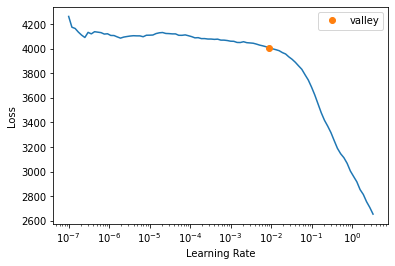

In [64]:
lr_value=learn.lr_find()


In [70]:
learn.fit_one_cycle(250,0.045)



epoch,train_loss,valid_loss,_rmse,time
0,0.911131,34.645069,5.886006,00:00
1,2.647093,35.636581,5.969638,00:00
2,3.020693,34.276978,5.854654,00:00
3,2.331683,34.564697,5.879175,00:00
4,2.191436,34.528019,5.876055,00:00
5,2.132550,34.843441,5.902833,00:00
6,2.299156,36.318222,6.026460,00:00
7,2.085892,36.512817,6.042583,00:00
8,2.009017,36.319820,6.026593,00:00
9,2.194580,36.457108,6.037972,00:00


In [71]:
learn.show_results()

,BATTERY_ID,EIS_ID,Z_f0_real,Z_f0_imag,Z_f1_real,Z_f1_imag,Z_f2_real,Z_f2_imag,Z_f3_real,Z_f3_imag,Z_f4_real,Z_f4_imag,Z_f5_real,Z_f5_imag,Z_f6_real,Z_f6_imag,Z_f7_real,Z_f7_imag,Z_f8_real,Z_f8_imag,Z_f9_real,Z_f9_imag,Z_f10_real,Z_f10_imag,Z_f11_real,Z_f11_imag,Z_f12_real,Z_f12_imag,Z_f13_real,Z_f13_imag,SOC_float,SOC_float_pred
0,1.0,9.0,0.190585,1.417046,0.229817,1.243992,0.256179,1.236268,0.285251,1.172092,0.317412,0.717506,0.327347,0.645190,0.351270,0.507657,0.381413,0.306290,0.414810,0.432169,0.421641,0.589153,0.467011,0.799951,0.494992,0.566467,0.504413,0.570764,0.518909,0.236608,30.0,29.901051
1,1.0,7.0,0.257056,1.279788,0.287841,1.050924,0.312213,1.157640,0.335155,0.869857,0.373961,0.750161,0.400533,0.465785,0.432186,0.480285,0.450864,0.178511,0.473639,0.208306,0.486584,0.402229,0.498747,0.190799,0.510167,0.014464,0.508708,0.066411,0.522983,-0.227395,30.0,36.393257
2,1.0,7.0,0.160182,1.413162,0.198363,1.320436,0.224023,1.212844,0.247285,1.337372,0.279631,0.862235,0.305494,0.709012,0.339501,0.804186,0.385701,0.756915,0.420538,0.676522,0.450772,0.429950,0.458589,0.359032,0.475600,0.357146,0.486691,0.267888,0.486798,-0.197327,40.0,46.072987
3,1.0,1.0,-1.855081,1.534198,-1.845413,1.444617,-1.828736,1.332749,-1.819689,1.155817,-1.814270,1.027318,-1.820457,0.747520,-1.820690,0.684057,-1.854569,0.384911,-1.878280,0.597587,-1.907882,0.542687,-1.923117,0.951799,-1.919515,1.358998,-1.924972,1.477823,-1.910141,1.701879,20.0,22.994104
4,1.0,7.0,0.605073,-0.374514,0.644247,0.284094,0.675033,0.137296,0.672742,-0.007933,0.683001,-0.113150,0.697671,-0.215212,0.680359,-0.788275,0.681203,-1.221041,0.629773,-1.661048,0.592312,-1.638872,0.523616,-1.741074,0.499498,-1.628105,0.466204,-1.759294,0.450291,-1.929464,100.0,98.459564
5,1.0,2.0,-2.218646,1.952544,-2.213161,1.654499,-2.200001,1.528544,-2.181008,1.432387,-2.178583,1.280453,-2.182010,1.359920,-2.176443,1.394468,-2.178460,1.605949,-2.152997,1.816123,-2.120690,1.871020,-2.085705,2.075256,-2.079548,2.376464,-2.058036,2.474788,-2.054072,2.157545,50.0,41.546658
6,1.0,3.0,0.355953,0.596390,0.360382,0.016200,0.339048,0.022010,0.348829,0.291348,0.352888,0.259200,0.372120,0.282905,0.406486,0.172692,0.416857,-0.018760,0.425285,-0.243250,0.414494,-0.488518,0.379621,-0.833525,0.384834,-0.748453,0.380065,-0.468639,0.372838,-0.632505,60.0,50.890507
7,1.0,4.0,0.423090,-0.404377,0.375853,-1.204199,0.334064,-0.628609,0.338312,-0.202650,0.338586,-0.028078,0.346583,0.106884,0.382221,0.313469,0.402298,0.424803,0.426650,0.272033,0.451430,0.210909,0.460442,-0.054396,0.448132,-0.131099,0.455140,-0.069991,0.450917,-0.045944,60.0,60.139561
8,1.0,7.0,0.414213,-0.517276,0.415073,-0.511673,0.398347,-0.385805,0.400098,-0.330263,0.391988,-0.224867,0.407100,0.013742,0.412882,-0.101753,0.447637,0.047207,0.460692,-0.094797,0.450861,-0.098263,0.447892,-0.345601,0.463758,-0.565080,0.449600,-0.576266,0.454093,-0.643430,90.0,89.780540


In [72]:
from sklearn.metrics import mean_squared_error
[y_pred,y_true] =learn.get_preds()
mean_squared_error(y_true,y_pred,squared=False)

5.0008163

In [73]:
learn.save('EIS_tabular_regression_rect')

Path('models/EIS_tabular_regression_rect.pth')